In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

Boulder Opal client update available.
Latest version is 2.0.1, you have 1.4.0.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


In [2]:
graph = bo.Graph()
segment_count = 80*2

In [3]:
# Pulse parameters.

duration = 0.5*segment_count*1e-9  # s

# Maximum value for |α(t)|.
alpha_max = 0.07*2*np.pi*1e9  # rad/s
envelope_signal = graph.signals.cosine_pulse_pwc(
    duration=duration, segment_count=segment_count, amplitude=1.0,flat_duration=0.9 * duration,
)

# Real PWC signal representing α(t).
I = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    minimum=-alpha_max,
    maximum=alpha_max,
    name="$\\I$",
)
RI = graph.filter_and_resample_pwc(
    pwc=I,
    kernel=graph.sinc_convolution_kernel(5/duration*2*np.pi),
    segment_count=segment_count,
    name="$L(\\I)$",
)
ORI = envelope_signal*RI
ORI.name = "$\\Omega L(\\I)$"

Q = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    minimum=-alpha_max,
    maximum=alpha_max,
    name="$\\Q$",
)
RQ = graph.filter_and_resample_pwc(
    pwc=Q,
    kernel=graph.sinc_convolution_kernel(10/duration*2*np.pi),
    segment_count=segment_count,
    name="$L(\\Q)$",
)
ORQ = envelope_signal*RQ
ORQ.name = "$\\Omega L(\\Q)$"

In [4]:
dim = 5
anh = -0.2*2*np.pi*1e9
import qutip as qt
import scipy.special as sp
N_q = 5
a_q = qt.destroy(N_q)
n_q = a_q.dag() * a_q
H0 =  1/2*anh* a_q.dag()**2 * a_q**2
Hcx=a_q+a_q.dag()
Hcy=-a_q*1j+1j*a_q.dag()
H0=H0.data.toarray()
Hcx=Hcx.data.toarray()
Hcy=Hcy.data.toarray()
detuning = 0.01*2*np.pi*1e9
dephasing = detuning*a_q.dag()*a_q

In [5]:
# Total Hamiltonian.
hamiltonian = H0+ORI*Hcx+ORQ*Hcy

In [6]:
import numpy as np
def Rx(matrix,angle):
    matrix[0,0]=np.cos(angle/2)
    matrix[0,1]=-1j*np.sin(angle/2)
    matrix[1,0]=-1j*np.sin(angle/2)
    matrix[1,1]=np.cos(angle/2)
    return matrix
targets=np.zeros([dim ,dim ],dtype=complex)
angle = np.pi
targets=Rx(targets,angle)
qubit_projector = np.pad(np.eye(2), ((0, 3), (0, 3)), mode="constant")


In [7]:
target_operator = graph.target(
    targets, filter_function_projector=qubit_projector
)


In [8]:
target_operator

<Target: operation_name="target", value_shape=(5, 5)>

In [9]:
infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    target=target_operator,
    name="infidelity",
)
robust_infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    noise_operators=[dephasing],
    target=target_operator,
    name="robust_infidelity",
)

In [10]:
optimization_result = bo.run_optimization(
    cost_node_name="robust_infidelity",
    output_node_names=["$\\I$", "$\\Q$","$L(\\I)$", "$L(\\Q)$","$\\Omega L(\\I)$","$\\Omega L(\\Q)$",],
    graph=graph,
    optimization_count=200,
)

print(f"\nOptimized cost:\t{optimization_result['cost']:.3e}")

Your task (action_id="2015297") has started.
Your task (action_id="2015297") has completed.

Optimized cost:	3.564e-08


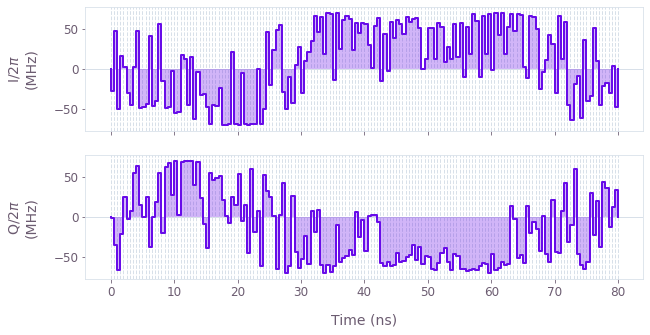

In [11]:
import qctrlvisualizer as qv
qv.plot_controls(
    {
        "I": optimization_result["output"]["$\\I$"],
        "Q": optimization_result["output"]["$\\Q$"],
    },
    polar=False,
)

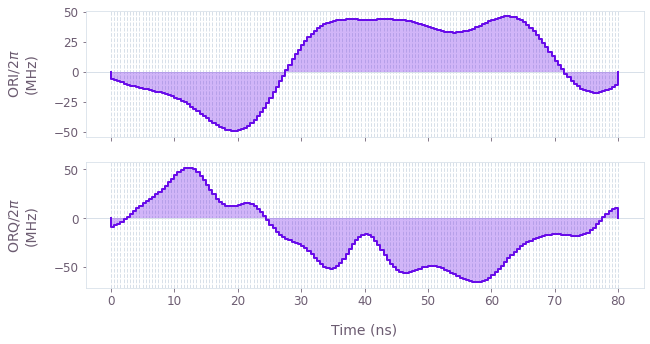

In [12]:
import qctrlvisualizer as qv
qv.plot_controls(
    {
        "ORI": optimization_result["output"]["$L(\\I)$"],
        "ORQ": optimization_result["output"]["$L(\\Q)$"],
    },
    polar=False,
)

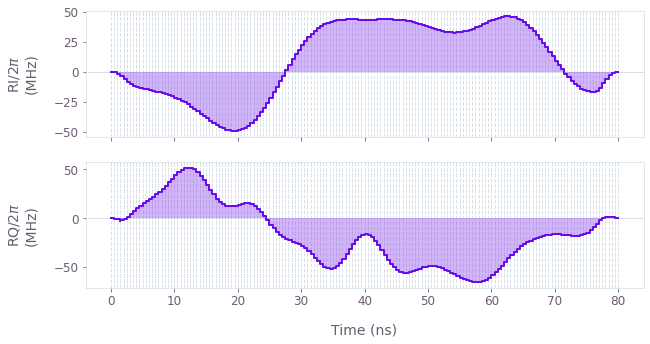

In [13]:
import qctrlvisualizer as qv
qv.plot_controls(
    {
        "RI": optimization_result["output"]["$\\Omega L(\\I)$"],
        "RQ": optimization_result["output"]["$\\Omega L(\\Q)$"],
    },
    polar=False,
)

In [14]:
controlI = []
durations = optimization_result["output"]["$\\Omega L(\\I)$"]['durations']
results = optimization_result["output"]["$\\Omega L(\\I)$"]['values']
for i in range(len(durations)):
    if durations[i]>1e-15:
        controlI.append(results[i]/1e9)
controlI = np.array(controlI)
controlQ = []
durations = optimization_result["output"]["$\\Omega L(\\Q)$"]['durations']
results = optimization_result["output"]["$\\Omega L(\Q)$"]['values']
for i in range(len(durations)):
    if durations[i]>1e-15:
        controlQ.append(results[i]/1e9)
controlQ = np.array(controlQ)

In [15]:
# transmon anharmonicity
k_q = -200e-3 * 2*np.pi  
#transmon truncation level
N_q = 5
#duration
total_time = segment_count/2
#number of time intervals for AWG
total_time_steps=len(controlI)
#target
angle= np.pi
#range of δ you care
fluc=np.arange(-10,10)*2*np.pi*1e-3

In [16]:
pulse=[controlI,controlQ]
# Qutip will do interpolation for drive, which distort piece-wise-constant control. 
# Here I manually do interpolation to make sure piece-wise-constant pulse.
resolution = 100
times = np.linspace(0, total_time, total_time_steps*resolution+1)
times=np.delete(times, [len(times) - 1])
osc_control=np.array([np.cos(2*np.pi*5*times),np.sin(2*np.pi*5*times)])
best_controls=np.zeros_like(osc_control)
for m in range(len(best_controls)):
    for i in range(len(pulse[0])): 
        for j in range(resolution):
            best_controls[m][i*resolution+j]=pulse[m][i]*(1)

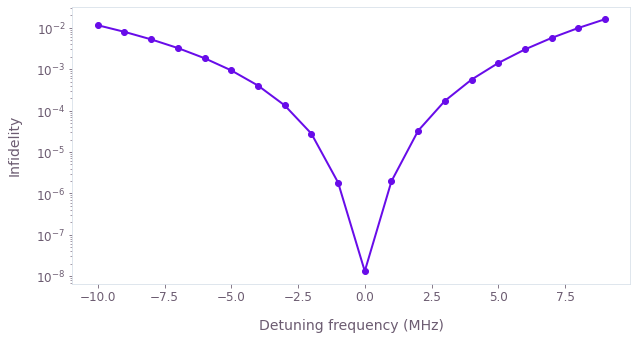

In [17]:
def Rx(matrix,angle):
    matrix[0,0]=np.cos(angle/2)
    matrix[0,1]=-1j*np.sin(angle/2)
    matrix[1,0]=-1j*np.sin(angle/2)
    matrix[1,1]=np.cos(angle/2)
    return matrix
import qutip as qt
from qutip import *
import scipy.special as sp
target_states=np.zeros([N_q,N_q],dtype=complex)
target_states=Rx(target_states,angle)
a_q = destroy(N_q)
n_q = a_q.dag() * a_q
x_q = a_q + a_q.dag()
cross = 0e-3 * 2*np.pi
# without -1/2, strange result when change time origin
H0 =  1/2*k_q * a_q.dag()**2 * a_q**2
Hcx=a_q+a_q.dag()
Hcy=-a_q*1j+1j*a_q.dag()
H0=H0.data.toarray()
Hcx=Hcx.data.toarray()
Hcy=Hcy.data.toarray()
H_controls=[Hcx,Hcy]
U_ideal=qt.Qobj(target_states)
#infidelity withought fluctuation
import qutip as qt
options = qt.Options(rtol=1e-10, atol=1e-10)
qt_H0=qt.Qobj(H0)

qt_Hcx=qt.Qobj(H_controls[0])
qt_Hcy=qt.Qobj(H_controls[1])
qt_tlist=times

fluc_oper=n_q
infidelities=np.zeros(len(fluc))
infidelities_robust=np.zeros(len(fluc))
options = qt.Options(rtol=1e-10, atol=1e-10)
U_ideal=qt.Qobj(target_states)
x=np.pi/angle
for i in range(len(fluc)):
    qt_H0=qt.Qobj(H0+fluc[i]*fluc_oper)
    qt_tlist=times
    qt_cx = best_controls[0]
    qt_cy = best_controls[1]
    qt_H=[qt_H0,[qt_Hcx,qt_cx],[qt_Hcy,qt_cy]]
    output = qt.propagator(qt_H, qt_tlist, options=options)
    infidelities[i]=1-np.abs(np.trace((U_ideal*output[-1].dag())))**2/4
fig,ax=plt.subplots()
ax.plot(fluc/(2*np.pi)*1e3,infidelities)
ax.set_xlabel('Detuning frequency (MHz)')
ax.set_ylabel('Infidelity')
ax.scatter(fluc/(2*np.pi)*1e3,infidelities)
ax.set_yscale('log')

In [18]:
np.mean(infidelities)

0.0034161654833182453

In [19]:
np.std(infidelities)

0.0045221039424167345

In [20]:
np.save('qcpi_80.npy', pulse)